In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
import time

### 3 days left before you have to send pre-read materials 

#### TODO:
- time dimension
    - yoy planting constraint (kill plants that don't go well with what was planted the year before)
    - perrenials need to be planted in the same bed yoy

- consider swapping out algorithm

- consider changing wording of plant to vegetable or veg or produce or crop or provision
- look into parallel processing. potentially have notebook run in AWS
- potential convert to class
- look into random seed best practices
- fill in documentation to make this easier to walk through during the workshop
- formulate and implement a MIP to solve the same problem
- figure out some good pre-read materials
- visualize solution space
- visualizations at the end
- visual showing maps and heat (sun)
- add gif showing simulated annealing
- email chris this notebook and let him decide if we should do both 

In [2]:
plant_info = pd.read_csv('../data/plant_data.csv')
bed_info = pd.read_csv('../data/bed_data.csv')

In [3]:
# plant_info = plant_info.head(5).copy()
# bed_info = bed_info.head(10).copy()

In [4]:
plant_info.index.name = 'plant_index'
plants = plant_info.plant.to_numpy()
plant_index = plant_info.index.to_numpy()
num_plants = len(plants)

In [5]:
bed_info.index.name = 'bed_index'
beds = bed_info.bed.to_numpy()
bed_index = bed_info.index.to_numpy()
num_beds = len(beds)

#for keeping track of what axis is which
bed_axis = 0
plant_axis = 1

bed_width = 3
bed_length = 10
bed_capacity = bed_length*12

In [6]:
bed_info

,bed,sun,x,y
bed_index,,,,
0,1,Full sun,0,0
1,2,Partial sun,1,0
2,3,Partial shade,2,0
3,4,Full sun,0,1
4,5,Partial sun,1,1
5,6,Partial shade,2,1
6,7,Full sun,0,2
7,8,Partial sun,1,2
8,9,Partial shade,2,2


In [7]:
42

42

In [8]:
bed_info.sun.map({'Full sun':1,'Partial sun':2,'Partial shade':3}).to_numpy().reshape(3,14)

array([[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2],
       [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
       [2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]], dtype=int64)

In [9]:
# sns.color_palette('f')

In [10]:
print(num_beds)
print(beds)
print(bed_index)

42
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [11]:
#average preference
family = ['evan','gina','liesse','lizzie','jack']
plant_info['avg_pref'] = np.average(plant_info[family],axis=1,weights=[.5,.5,0,0,0])
plant_info.drop(family,axis=1,inplace=True)
preferences = plant_info.avg_pref.to_numpy()
plant_index_by_pref = plant_info.sort_values('avg_pref',ascending=False).index 

plant_spacing = plant_info.plant_spacing.to_numpy()

In [12]:
# preferences[0] = 100

In [13]:
#get plant and bed sun requirements
plant_sun_req = plant_info.sun.to_numpy()
bed_sun_req = bed_info.sun.to_numpy()

In [14]:
#initialize sun constraint
sun_constraint = np.ones(shape=(num_beds,num_plants))

for b in bed_index:
    for p in plant_index:
        b_sun = bed_sun_req[b]
        p_sun = plant_sun_req[p]
        if b_sun != p_sun:
            sun_constraint[b][p] = 0

In [15]:
plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

2

In [16]:
#most preferred 
max_pref = plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

In [17]:
#convert info dfs to dicts
# plant_info = plant_info.to_dict(orient='index')
# bed_info = bed_info.to_dict(orient='index')

In [18]:
#initialize plan. no plants in any bed
# np.random.seed(2134)
np.random.seed(1234)
# initial_plan = np.random.choice([0,1],size=(num_beds,num_plants))
initial_plan = np.zeros(shape=(num_beds,num_plants))

#put a random crop in each bed
for bed in bed_index:
    plant = np.random.choice(plant_index)
    initial_plan[bed][plant] = 1
    
print(initial_plan)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
# initial_plan[:,2] = 1

In [20]:
# def make_neighbor(plan,iteration,cycle_size=5000):
#     """
#     iteration: 
#     cycle_size: 
#     """
#     #pick a random bed
#     bed = np.random.choice(bed_index)
#     #pick a random plant
#     plant = np.random.choice(plant_index)
#     #plant in bed if not already. Otherwise remove. 
#     decision = abs(plan[bed][plant]-1)

#     #make a decision
#     new_plan = plan.copy()
#     new_plan[bed][plant] = decision
#     # print(new_plan.sum())
#     return new_plan

def make_neighbor(plan):
    """
    iteration: 
    cycle_size: 
    """
    #pick a random bed
    bed = np.random.choice(bed_index)
    #pick a random plant
    plant = np.random.choice(plant_index)

    #implement decision
    new_plan = plan.copy()
    new_plan[bed] = np.zeros(shape=(1,num_plants))
    new_plan[bed][plant] = 1
    # print(new_plan.sum())
    return new_plan

In [21]:
# def enforce_sun_constraint(plan,bed_sun_req,plant_sun_req):
#     """
#     Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
#     """
#     plan_sun = plan.copy()
#     for b in bed_index:
#         for p in plant_index:
#             b_sun = bed_sun_req[b]
#             p_sun = plant_sun_req[p]
#             if b_sun != p_sun:
#                 plan_sun[b][p] = 0
#     return plan_sun

def enforce_sun_constraint(plan,sun_constraint):
    """
    !!!!update
    Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
    """
    return plan*sun_constraint

In [22]:
def compute_yield(plan):
    """
    Yield is the % of plants that are planted and survive. Not all plants will survive where they are planted.
    This is where we impose constraints on sun requirements, year-over-year planting requirements, and companion planting requirements.
    Returns the total number of surviving plants / the total plants planted.
    """
    # 
    #Too little/too much sun can kill certain plants
    #Some plants don't do well depending on what was planted the year before
    #Some plants don't go well next to each other
    #denominator. total number of plants planted
    total_plants_planted = plan.sum()+1 #+1 avoids div by zero error  
    
    plan_yield = plan.copy()

    #impose constraints that kill plants in beds where they are not supposed to be
    plan_yield = enforce_sun_constraint(plan_yield,sun_constraint)
        
    # plan = yoy_planting_constraint(plan)
    # plan = companion_planting_constraint(plan)
    yield_ = (plan_yield.sum()/total_plants_planted)*100
    return plan_yield,yield_

def compute_yummy_score(plan,preferences):
    """Takes the weighted average of the preferences of each plant, weighted by the total qty of plants 
    in the current plan for each plant. Maximization encourages plants with higher preferences to be planted in higher quantities."""
    plan_yummy = plan.copy()
    plan_by_plant = plan_yummy.sum(axis=bed_axis)#/plan_yummy.sum() 
    yums = np.average(preferences,weights=plan_by_plant+1)*10 #+1 avoids div by 0
    # yums = sum(preferences*plan_by_plant)
    return yums

def compute_variety_score(plan,num_plants):
    """Sums the number of unique plants that are actually planted in the garden. Counts the number of plants that are being planted across all beds.
       Then counts the number of plants with non-zero planting plan. 
       Maximization encourages more unique plants to be planted."""
    plan_variety = plan.copy()
    variety_score = (plan_variety.sum(axis=bed_axis) > 0).sum()/num_plants*100
    return variety_score

In [23]:
# best_plan.sum(axis=bed_axis)/best_plan.sum()

In [24]:
def get_objective(plan,weights,initial_obj_values):
    plan, yield_ = compute_yield(plan)
    yummy_score = compute_yummy_score(plan,preferences)
    variety_score = compute_variety_score(plan,num_plants)
    objective = (
                (weights['yield_']*yield_) / initial_obj_values['yield_']
              + (weights['yummy_score']*yummy_score) / initial_obj_values['yummy_score'] 
              + (weights['variety_score']*variety_score) / initial_obj_values['variety_score']
                )
    # return (objective,{'objective':objective,'yield_':yield_})
    return (objective,{'objective':objective,'yield_':yield_,'yummy_score':yummy_score,'variety_score':variety_score})

In [25]:
def optimize(initial_plan,weights,starting_temperature=10000,alpha=0.99,max_SA_iter=10000,max_hone_iter=1000):
    
    initial_obj_values = {'yield_': compute_yield(initial_plan)[1],
                          'yummy_score': compute_yummy_score(initial_plan,preferences),
                          'variety_score': compute_variety_score(initial_plan,num_plants)}

    current_plan = initial_plan.copy()
    current_objective,current_obj_values = get_objective(initial_plan,weights,initial_obj_values)
    
    best_plan = initial_plan.copy()
    best_objective = current_objective

    current_plan_obj_values = [(0,current_obj_values)]
    best_obj_values = [(0,current_obj_values)]
    total_planted = [(0,initial_plan.sum())]
    
    temperature = starting_temperature

    for i in range(max_SA_iter):
        # start = time.time()
        new_plan = make_neighbor(current_plan)
        # print('1:',(time.time()-start)*1000)
        # start = time.time()

        # print('2:',(time.time()-start)*1000)
        # start = time.time()
        new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)

        if new_objective > current_objective or np.exp(-(current_objective-new_objective) / temperature) > np.random.uniform():
            current_plan = new_plan.copy()
            current_objective = new_objective
            current_plan_obj_values.append((i,new_obj_values))
            total_planted.append((i,current_plan.sum()))

            
        # print('3:',(time.time()-start)*1000)
        # start = time.time()
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))      
        # print('4:',(time.time()-start)*1000)
        # start = time.time()
        #lower the temperature
        temperature = temperature*alpha
        

    #add step to hone the best found solution after SA is complete (only accept improvement)
    # for i in range(max_hone_iter):
    #     new_plan = make_neighbor(best_plan)

    #     new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)
    
    #     if new_objective > best_objective:
    #         best_plan = new_plan.copy()
    #         best_objective = new_objective
    #         best_obj_values.append((i,new_obj_values))
        
    
    return best_plan,best_objective,best_obj_values,current_plan_obj_values,total_planted

In [26]:
weights = {'yield_': .0,
           'yummy_score': 0,
           'variety_score': 1}

In [27]:
best_plan,best_objective,best_obj_values,current_plan_obj_values,total_planted = optimize(initial_plan,weights,max_SA_iter=10000,max_hone_iter=1000)

In [28]:
best_obj_values[-1][1]

{'objective': 1.0384615384615385,
 'yield_': 67.44186046511628,
 'yummy_score': 54.0,
 'variety_score': 75.0}

In [29]:
objectives = []
yields = []
yummy_scores = []
variety_scores = []
total_plants = []
for i in current_plan_obj_values:
    objectives.append(i[1]['objective'])
    yields.append(i[1]['yield_'])
    yummy_scores.append(i[1]['yummy_score'])
    variety_scores.append(i[1]['variety_score'])

for i in total_planted:
    total_plants.append(i[1])

df = pd.DataFrame([objectives,yields,yummy_scores,variety_scores,total_plants]).T#,yummy_scores,variety_scores]).T
df.columns = ['objective','yields','yummy_scores','variety_scores','total_plants']#,'yummy_score','variety_score']
df.reset_index(inplace=True)
df = df.melt(id_vars=['index','objective','total_plants'])

<AxesSubplot:xlabel='index', ylabel='objective'>

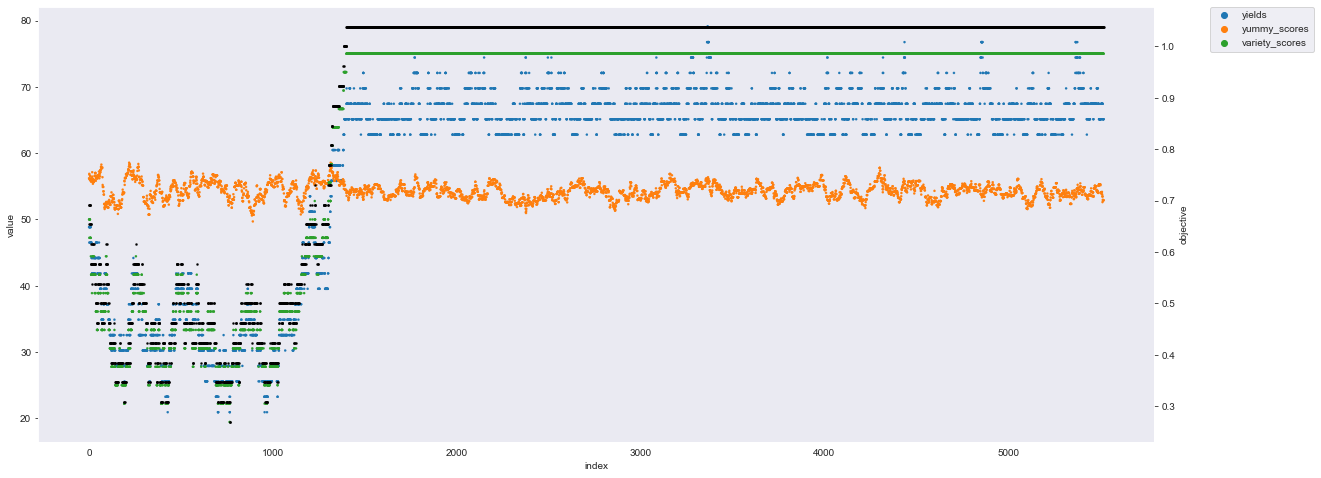

In [30]:
fig, ax = plt.subplots(figsize=(20,8))
sb.scatterplot(data=df,x='index',y='value',hue='variable',edgecolor=None,s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax2 = plt.twinx()
sb.scatterplot(data=df.drop_duplicates(['index','total_plants']),x='index',y='objective',edgecolor=None,ax=ax2,color='black',s=5)

In [31]:
plant_info['plan'] = best_plan.sum(axis=bed_axis)

In [32]:
plant_info[['avg_pref','plan']].corr()

,avg_pref,plan
avg_pref,1.000000,0.235463
plan,0.235463,1.000000


In [33]:
(plant_info.avg_pref*plant_info.plan).sum()

242.5

In [34]:
plant_info.groupby('sun').plan.sum()

sun
Full sun         23.0
Partial shade     6.0
Partial sun      13.0
Name: plan, dtype: float64

In [35]:
bed_info

,bed,sun,x,y
bed_index,,,,
0,1,Full sun,0,0
1,2,Partial sun,1,0
2,3,Partial shade,2,0
3,4,Full sun,0,1
4,5,Partial sun,1,1
5,6,Partial shade,2,1
6,7,Full sun,0,2
7,8,Partial sun,1,2
8,9,Partial shade,2,2


In [36]:
bed_plan = []
for i in best_plan:
    plant_idx = np.argmax(i)
    plant = plant_info.iloc[plant_idx].plant
    bed_plan.append(plant)
bed_info['plant'] = pd.Series(bed_plan)

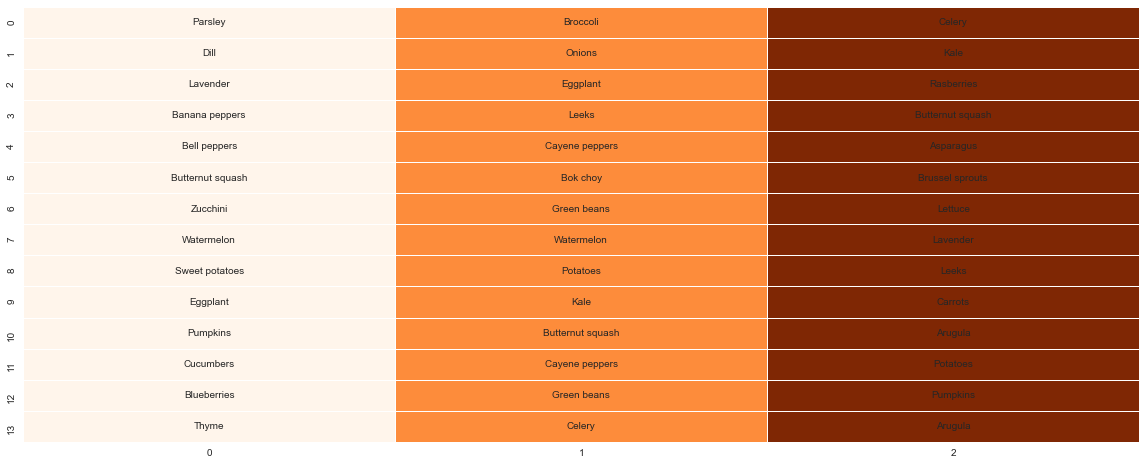

In [37]:
data = bed_info.sun.map({'Full sun':1,'Partial sun':2,'Partial shade':3}).to_numpy().reshape(14,3)
f, ax = plt.subplots(figsize=(20, 8))
ax = sb.heatmap(data,linewidths=.5,cmap='Oranges',cbar=False)

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, bed_info.loc[(bed_info.x==x)&(bed_info.y==y)].plant.iloc[0],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

In [38]:
plant_info.sort_values('avg_pref',ascending=False)

,plant,sun,plant_spacing,avg_pref,plan
plant_index,,,,,
2,Banana peppers,Full sun,24.00,9.5,1.0
1,Asparagus,Partial shade,12.00,9.5,1.0
11,Cayene peppers,Full sun,24.00,9.0,2.0
28,Rasberries,Full sun,28.00,8.5,1.0
12,Celery,Partial sun,12.00,8.5,2.0
9,Butternut squash,Full sun,12.00,8.5,3.0
16,Dill,Full sun,0.25,8.0,1.0
8,Brussel sprouts,Partial shade,24.00,8.0,1.0
15,Cucumbers,Full sun,12.00,7.5,1.0


In [39]:
best_plan.sum(axis=bed_axis)

array([2., 1., 1., 0., 1., 1., 1., 1., 1., 3., 1., 2., 2., 0., 0., 1., 1.,
       2., 2., 2., 2., 2., 1., 1., 0., 1., 2., 2., 1., 0., 0., 1., 0., 1.,
       2., 1.])